# NYC taxi example using One-Class SVM

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import svm
import sklearn.metrics as met

import rrcf
from rrcf.shingle import shingle

In [2]:
def metrics(labels, y_pred, name, sample):
    print(name,sample)
    print(met.precision_score(labels, y_pred))
    print(met.classification_report(labels, y_pred))

## Load and shingle data

In [3]:
data = np.load("taxi_all.npz")
data_passengers = data["passengers"]

data_dim = 48

data_stream = shingle(data_passengers, data_dim)
data_passengers_shingle = np.asarray(next(data_stream))
for i in range(1,len(data_passengers)-data_dim+1):
    data_passengers_shingle = np.vstack((data_passengers_shingle, next(data_stream)))

In [4]:
# Anamolies from the paper
labels = np.load('labels.npy')
labels = labels.astype(int)
# Labels anomalies as 1; otherwise 0
labels[labels == 1] = 0
labels[labels == -1] = 1

## Establish and run OC-SVM algorithm via scikit-learn

In [5]:
outliers_fraction = len(labels[labels==1])/len(labels)
algorithm = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)

In [6]:
np.random.seed(0)
nIters = 100
for sample_size in [256, 512, 1024]:
    for j in range(0,nIters):
        sample = np.random.choice(len(data_passengers_shingle),sample_size)
        algorithm.fit(data_passengers_shingle[sample,:])
        
    y_pred = algorithm.fit(data_passengers_shingle[sample,:]).predict(data_passengers_shingle)
    # Labels are assigned 1 if anomaly; else, label as 0
    y_pred[y_pred == -1] = 0
    
    print(metrics(labels[data_dim-1:], y_pred, "oc-svm", str(sample_size)))

oc-svm 256
0.0535714285714
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      9745
          1       0.05      0.01      0.01       528

avg / total       0.90      0.94      0.92     10273

None
oc-svm 512
0.0727272727273
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      9745
          1       0.07      0.02      0.03       528

avg / total       0.90      0.93      0.92     10273

None
oc-svm 1024
0.0571120689655
             precision    recall  f1-score   support

          0       0.95      0.91      0.93      9745
          1       0.06      0.10      0.07       528

avg / total       0.90      0.87      0.89     10273

None


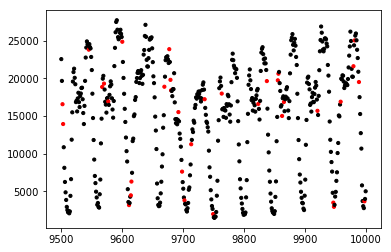

In [7]:
pltBegin = 9500
pltEnd = 10000
# Color detected anomalies in red
colors = np.array(['#000000', '#ff0000'])
plt.scatter(np.linspace(pltBegin,pltEnd-1,pltEnd-pltBegin),data_passengers[pltBegin:pltEnd], s=10, color=colors[y_pred.astype(int)])
plt.show()